### A net for sample detection

In [25]:
# imports

# keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD, Adagrad
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
import keras.backend as K

# weighted cross-entropy
from kerasFunctions import my_binary_crossentropy

In [8]:
# building the network

inputs = Input((None, None,1))
conv1 = Conv2D(8, (3, 3), strides=(1,1), activation='relu', padding='same', data_format='channels_last')(inputs)
# conv1 = Dropout(0.2)(conv1)
# conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
# conv2 = Dropout(0.2)(conv2)
# conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# #
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
# conv3 = Dropout(0.2)(conv3)
# conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = UpSampling2D(size=(2, 2))(conv3)
conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
# conv4 = Dropout(0.2)(conv4)
# conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# #
up2 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up2)
# conv5 = Dropout(0.2)(conv5)
# conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
#
# here nb_classes used to be just the number 2
conv6 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv5)
# conv6 = core.Reshape((2, 100*100))(conv6)
# conv6 = core.Permute((2,1))(conv6)
############

model = Model(inputs=inputs, outputs=conv6)
#     model.compile(optimizer=Adam(lr=0.0001), loss=my_categorical_crossentropy((1,100)), metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001), loss=my_binary_crossentropy((1,1)), metrics=['accuracy'])
#     model.compile(optimizer=Adam(lr=0.0000001), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])



In [220]:
import os
import tifffile

yes = []
no = []

dataDir = "../../../data/sample_detection/sampleDetectionDataset"
timeRange=10

if (os.path.isdir(dataDir)):
    yesPath = dataDir+"/sample/"
    noPath = dataDir+"/bg/"
   
    for fname in os.listdir(yesPath):
#         print(fname + "\n")
        if (fname.endswith("tif")):
            arr = tifffile.imread(yesPath+fname)
            yes.append(arr)
            
    for fname in os.listdir(noPath):
#         print(fname + "\n")
        if (fname.endswith("tif")):
            arr = tifffile.imread(noPath+fname)
            no.append(arr)
else:
    print("no such dir")

In [221]:
import numpy as np
from augment import generate_augmented_set

pos = np.array(yes[:-1])
neg = np.array(no[:-3])

pos_aug = generate_augmented_set(pos)
neg_aug = generate_augmented_set(neg)

x = np.concatenate((pos_aug,neg_aug))
y = np.concatenate((np.ones(pos_aug.shape), np.zeros(neg_aug.shape)))

X = x[...,np.newaxis]
Y = y[..., np.newaxis]

Augmented set generation...
Initial set size: 92x100x100
Final set size: 736x100x100
Augmented set generation...
Initial set size: 86x100x100
Final set size: 688x100x100


In [ ]:
model.fit(X, Y, epochs=100, batch_size=20)

Epoch 1/100
1424/1424 [==============================] - 17s 12ms/step - loss: 0.5050 - acc: 0.8132
Epoch 2/100
1424/1424 [==============================] - 18s 13ms/step - loss: 0.2714 - acc: 0.9038
Epoch 3/100
1424/1424 [==============================] - 18s 13ms/step - loss: 0.2605 - acc: 0.9062
Epoch 4/100
 280/1424 [====>.........................] - ETA: 14s - loss: 0.2087 - acc: 0.9285

In [44]:
from 

In [19]:
X.shape, Y.shape

((18, 100, 100, 1), (18, 100, 100, 1))

In [21]:
tpos = pos[-1]
tneg=neg[-1]

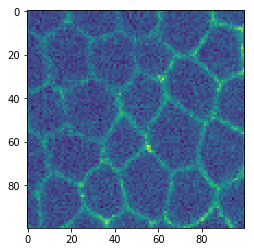

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(tpos)

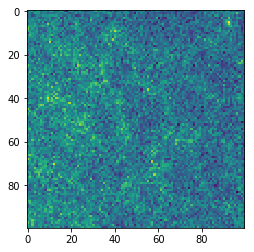

In [23]:
plt.imshow(tneg)

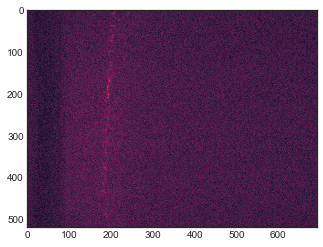

In [125]:
from qualityMeasure import *
testTile = readTile(pathToDataset="../resources/img/wing_of_hope/B=0/", tileNum=9, channelNum=3)
testFrame = testTile[40,:,:]
plt.imshow(testFrame)

In [147]:
pr = model.predict(testFrame[np.newaxis,:,:-1,np.newaxis])

(<matplotlib.image.AxesImage at 0x1243f6dd8>,
 <matplotlib.colorbar.Colorbar at 0x1253e4c88>)

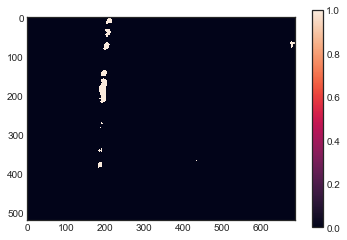

In [127]:
plt.imshow(pr[0,:,:,0]>.95), plt.colorbar()

In [142]:
profIntNet = []
for j in range(24):
        processedStack = np.zeros(testTile.shape)
        testTile = testTile = readTile(pathToDataset="../resources/img/wing_of_hope/B=0/", tileNum=j, channelNum=3)
        for i in range(testTile.shape[0]):
            processedStack[i,:,:] = 255*model.predict((testTile[i,:,:])[np.newaxis, :,:,np.newaxis])[0,:,:,0]
        profIntNet.append(getIntensityProfile(processedStack))

In [144]:
profIntNet = np.array(profIntNet)

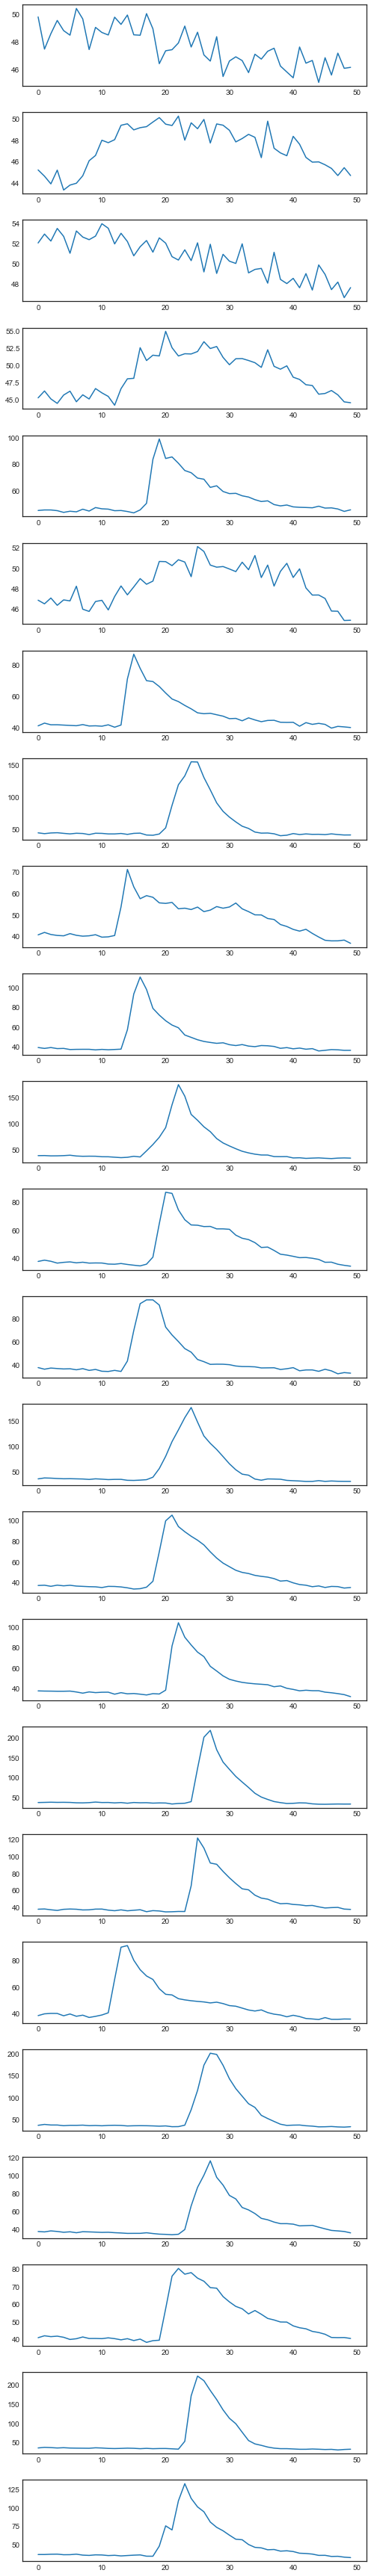

In [145]:
plotProfile(profIntNet)

In [129]:
tifffile.imsave("preocessedStack.tif", processedStack.astype("uint8"))

In [130]:
h = model.predict((testTile[22,:,:])[np.newaxis, :,:,np.newaxis])[0,:,:,0]

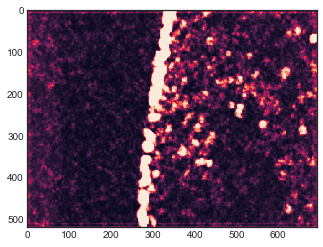

In [131]:
plt.imshow(processedStack[22,:,:])

In [138]:
profVarNet = getVarianceProfile(processedStack)
profIntNet = getIntensityProfile(processedStack>0.95*255)

In [139]:
np.var(processedStack[40,:,:])

828.74795507846352

In [140]:
import seaborn as sns
sns.set_style("white")

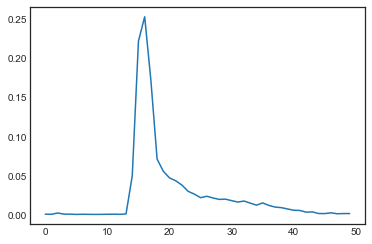

In [141]:
plt.plot(profIntNet)

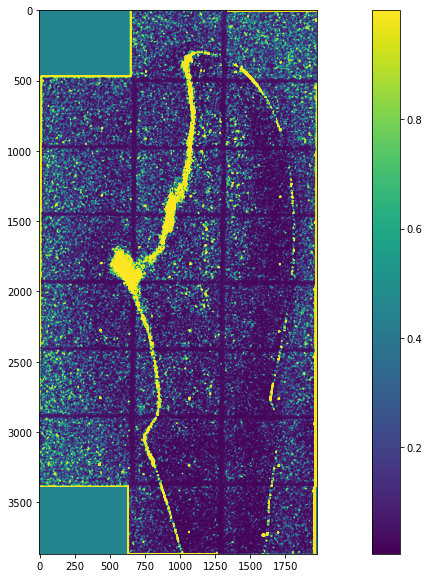

In [141]:
from pylab import rcParams
rcParams["figure.figsize"] =20,10
plt.imshow(pr[0,:,:,0]), plt.colorbar()
image.imsave("mask.png", pr[0,:,:,0])

In [26]:
y.shape

(18, 100, 100)

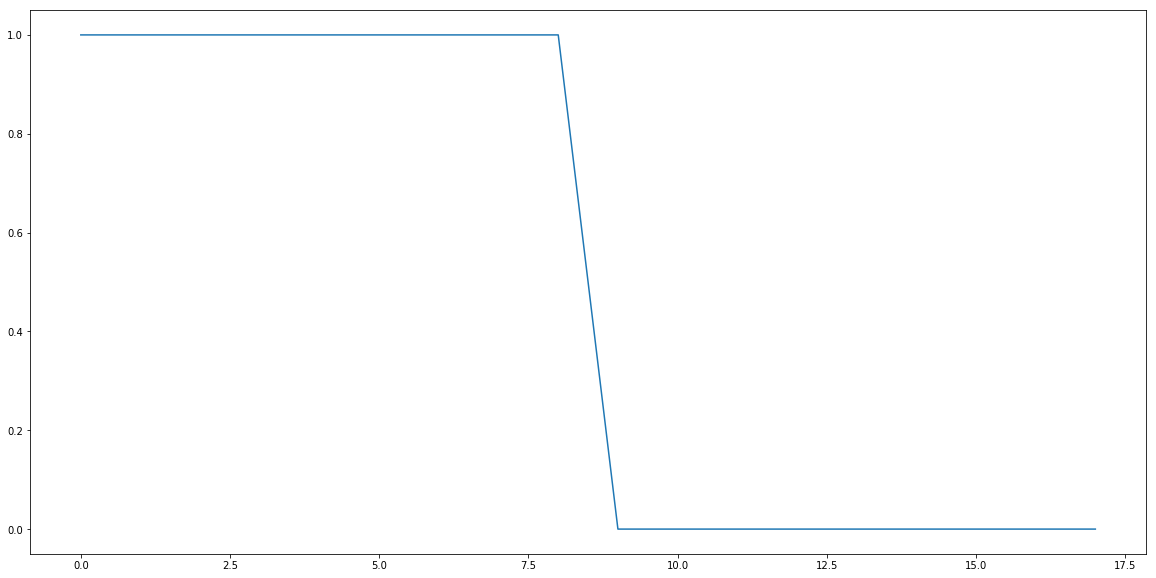

In [27]:
plt.plot(y[:,0,0])

In [28]:
from matplotlib import image

In [35]:
# full = image.imread("WT_25deg_160330_timelapseRaworiginal_140.png")[:,:,0]
full = tif2array("slice.tif")

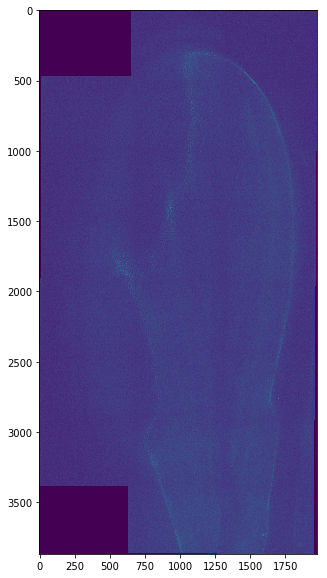

In [37]:
plt.imshow(full)

In [31]:
mask

NameError: name 'mask' is not defined

In [32]:
import gputools

[Errno 2] No such file or directory: 'C:\\cygwin64\\home\\myersadmin/.gputools'
<pyopencl.Device 'TITAN X (Pascal)' on 'NVIDIA CUDA' at 0x4da98ba0>


In [33]:
blur = gputools.blur(pr[0,:,:,0],width=20)
blur = gputools.blur(blur,width=20)
blur = gputools.blur(blur,width=20)

NameError: name 'pr' is not defined

In [ ]:
plt.imshow(blur>1.1*1e8), plt.colorbar()

In [50]:
full.shape

(3868, 1976)